[0.048302443702117205, 0.13836066570335834, 0.030373632158386822, 0.47785571396787696, 0.23936987169705162, 0.1597784468032167, 0.2473448874034839, 0.48244950694665456, 7.693462110088538, 0.16495601390223755, 0.6994309319476384, -1.1287147214371795]
[0.048302443702117205, 0.13836066570335834, 0.030373632158386822, 0.47785571396787696, 0.48244950694665456, 7.693462110088538, 0.16495601390223755, 0.6994309319476384, -1.1287147214371795]


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:411: RuntimeWarning: divide by zero encountered in double_scalars


<Figure size 1200x900 with 0 Axes>

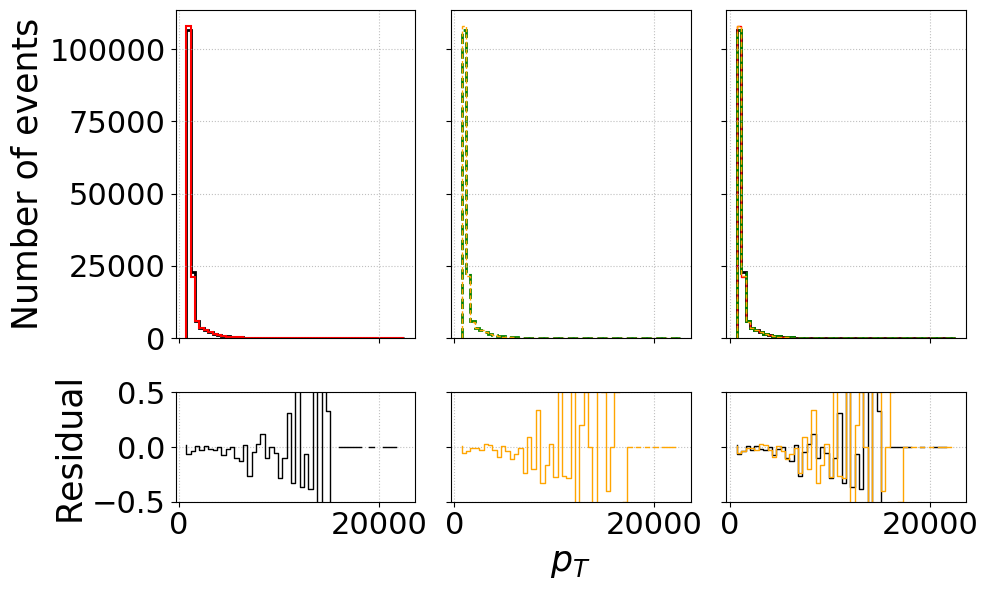

<Figure size 1200x900 with 0 Axes>

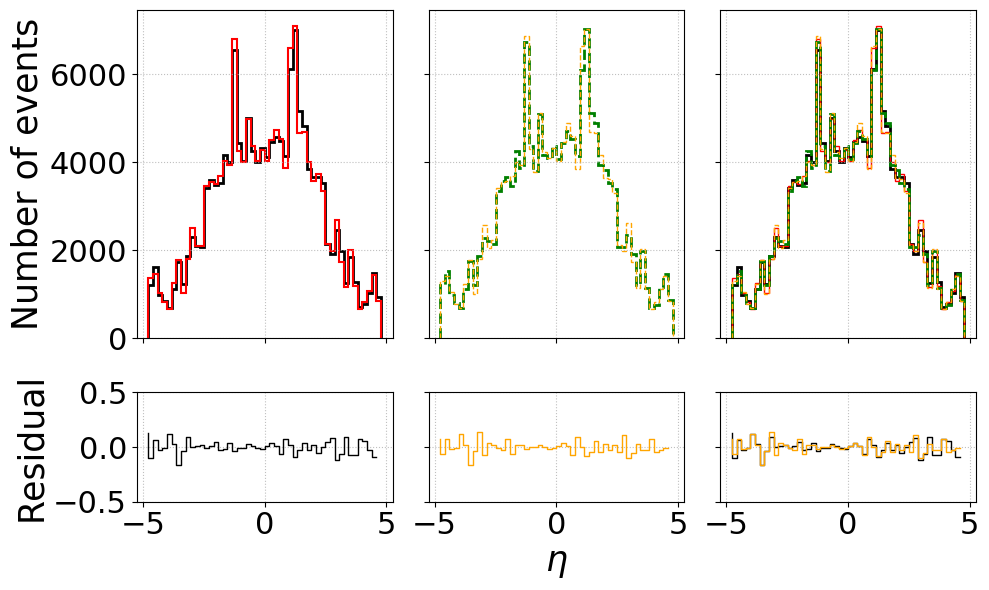

<Figure size 1200x900 with 0 Axes>

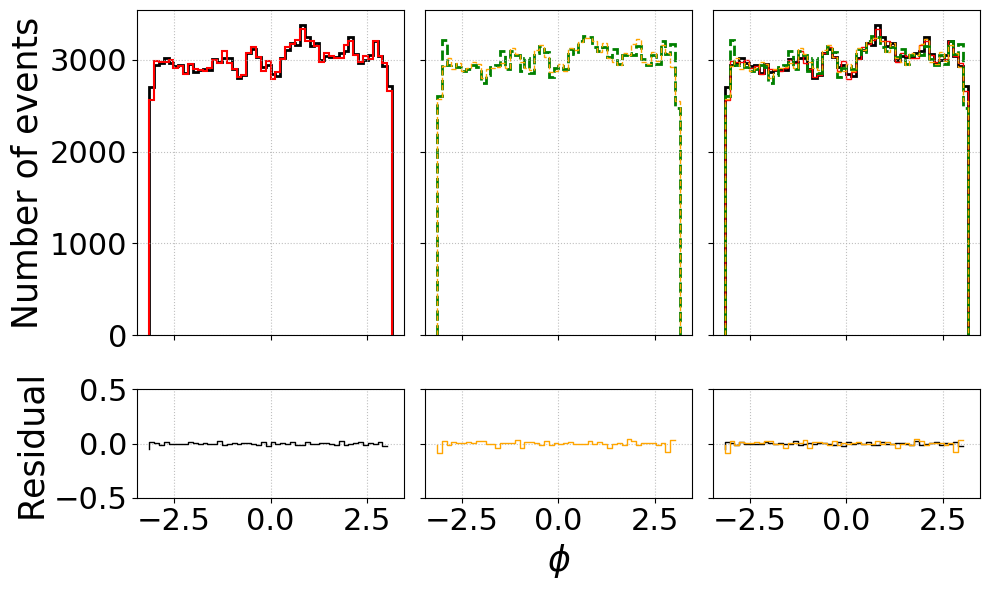

<Figure size 1200x900 with 0 Axes>

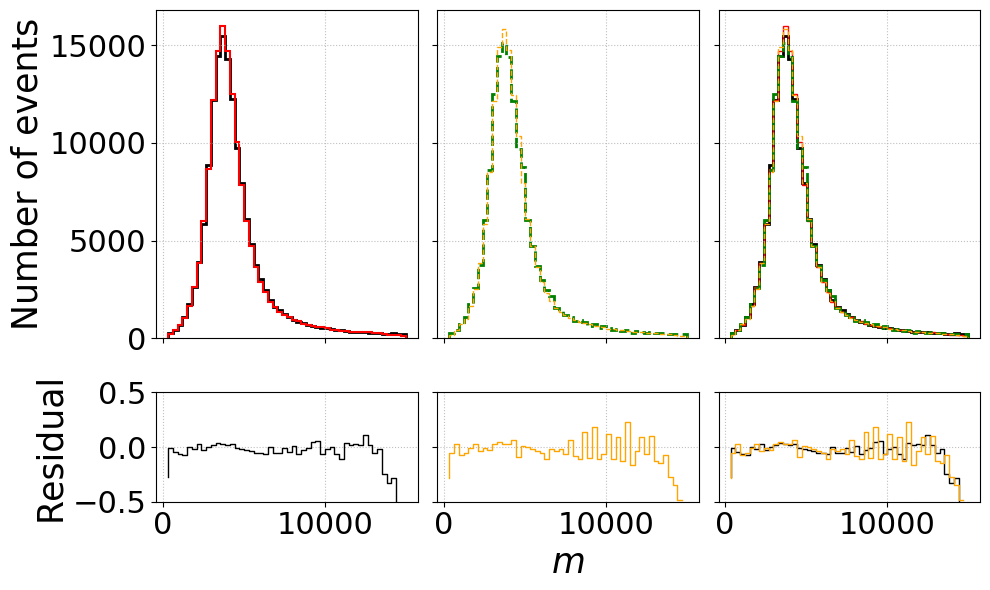

<Figure size 1200x900 with 0 Axes>

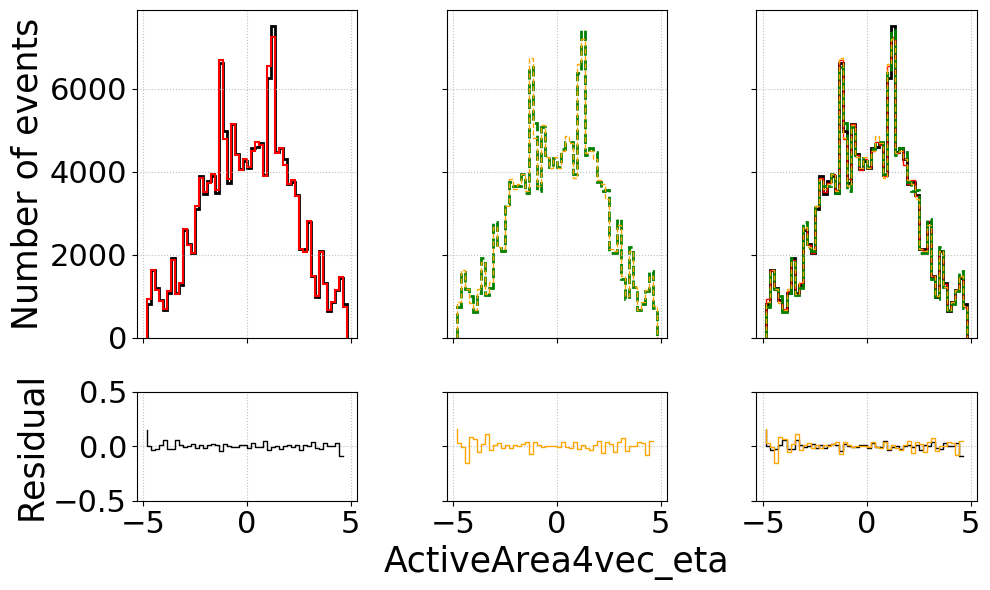

<Figure size 1200x900 with 0 Axes>

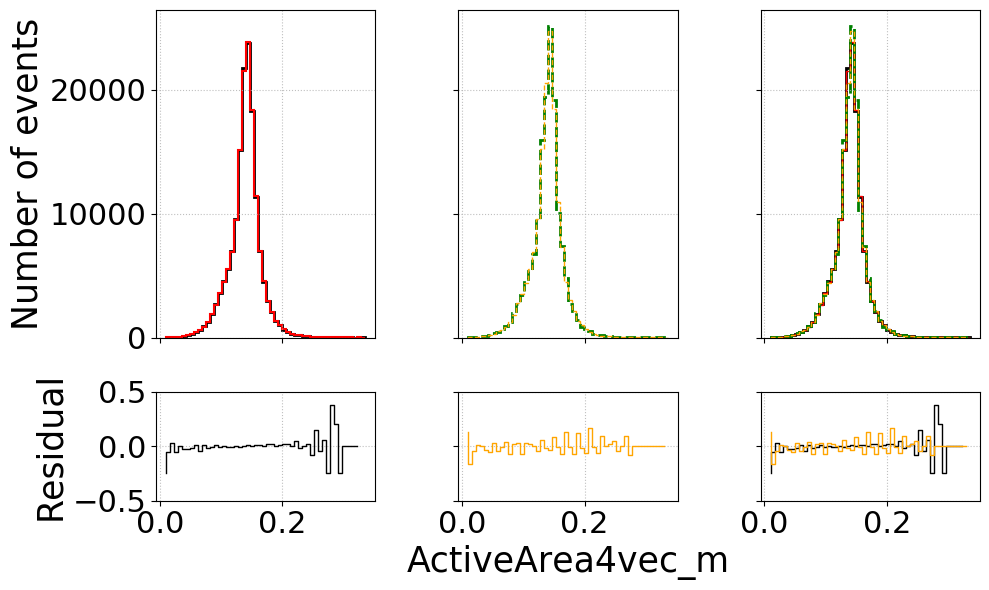

<Figure size 1200x900 with 0 Axes>

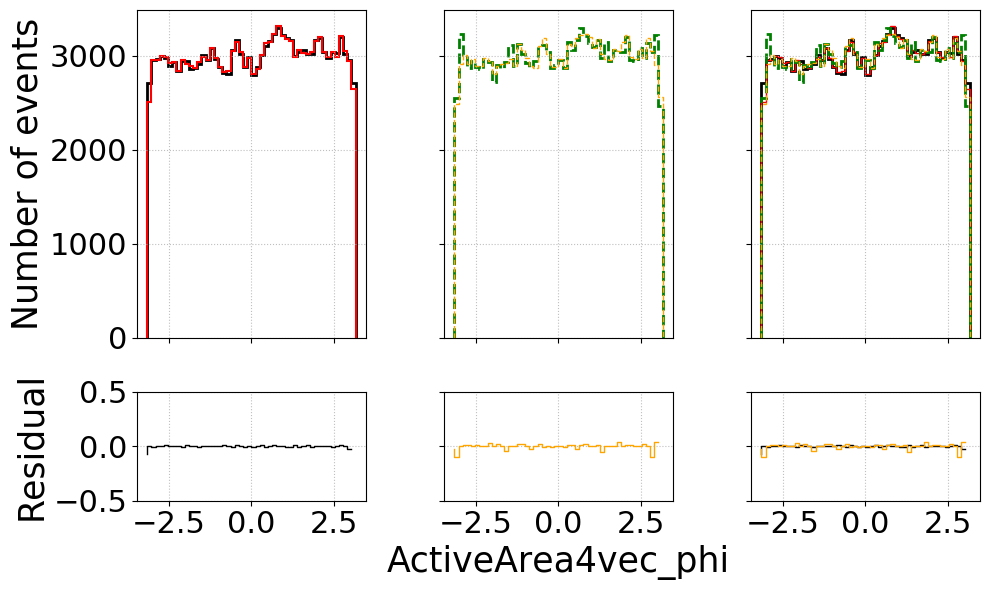

<Figure size 1200x900 with 0 Axes>

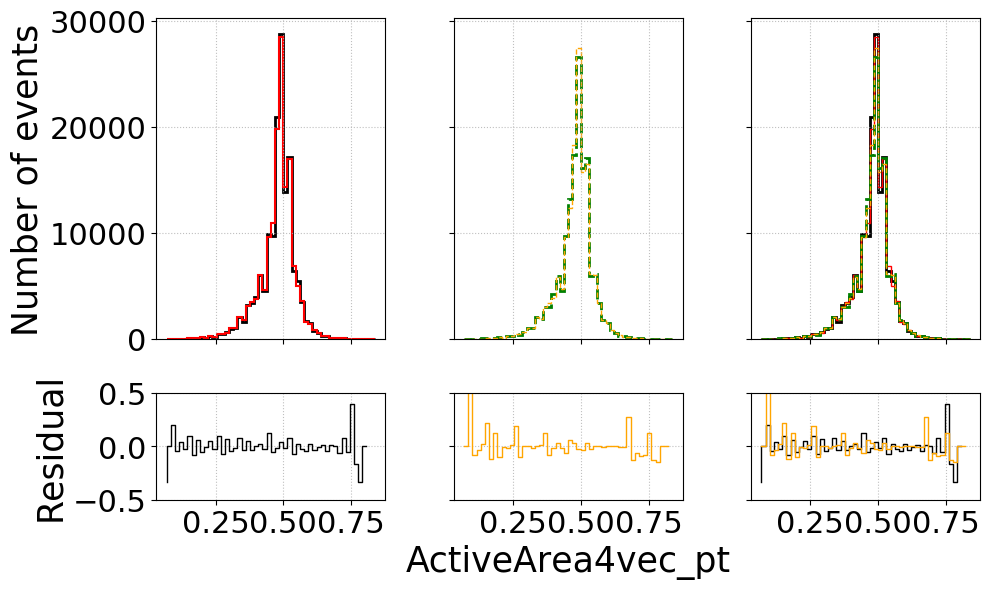

<Figure size 1200x900 with 0 Axes>

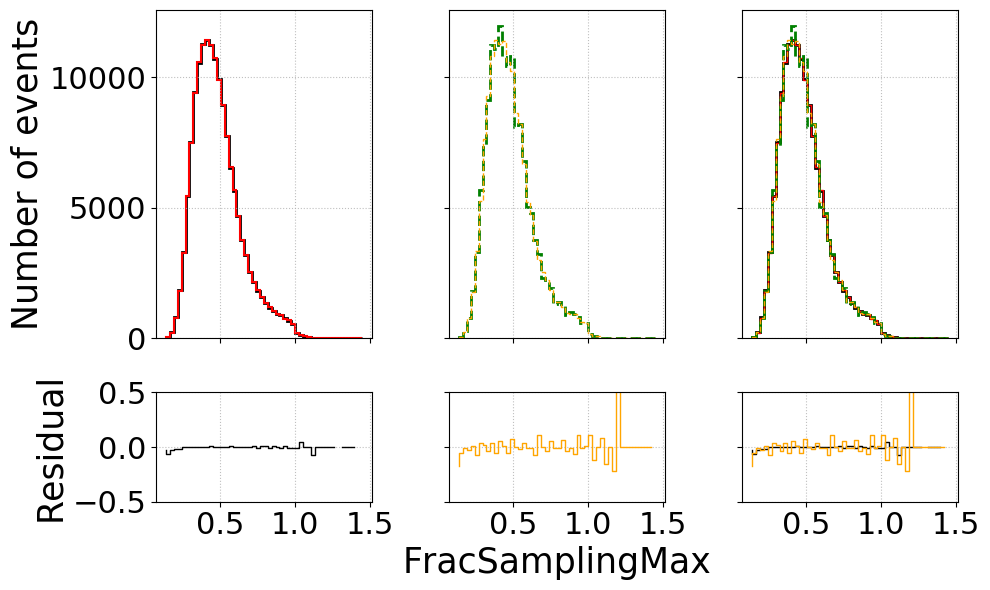

<Figure size 1200x900 with 0 Axes>

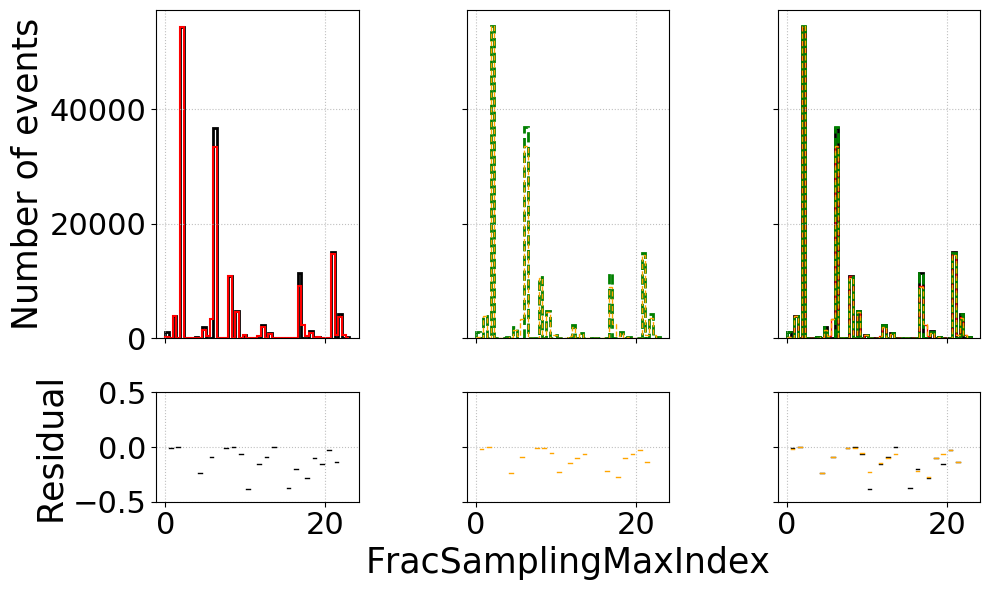

<Figure size 1200x900 with 0 Axes>

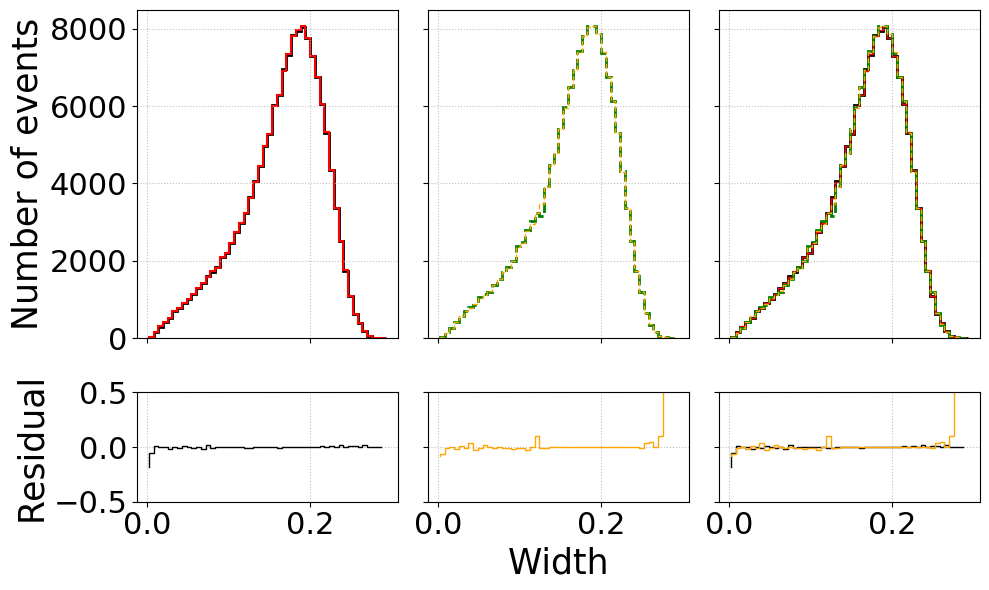

<Figure size 1200x900 with 0 Axes>

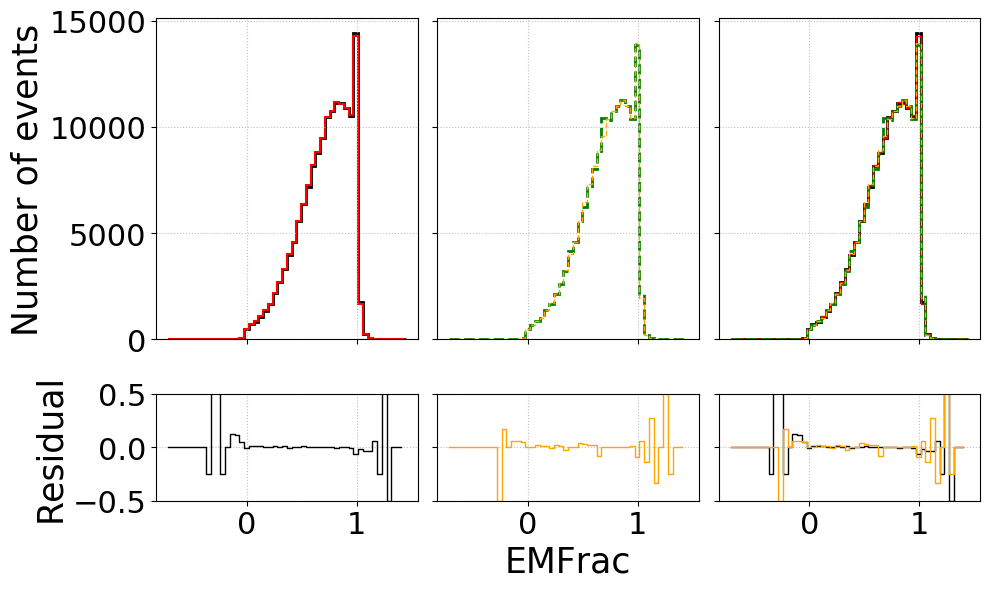

<Figure size 1200x900 with 0 Axes>

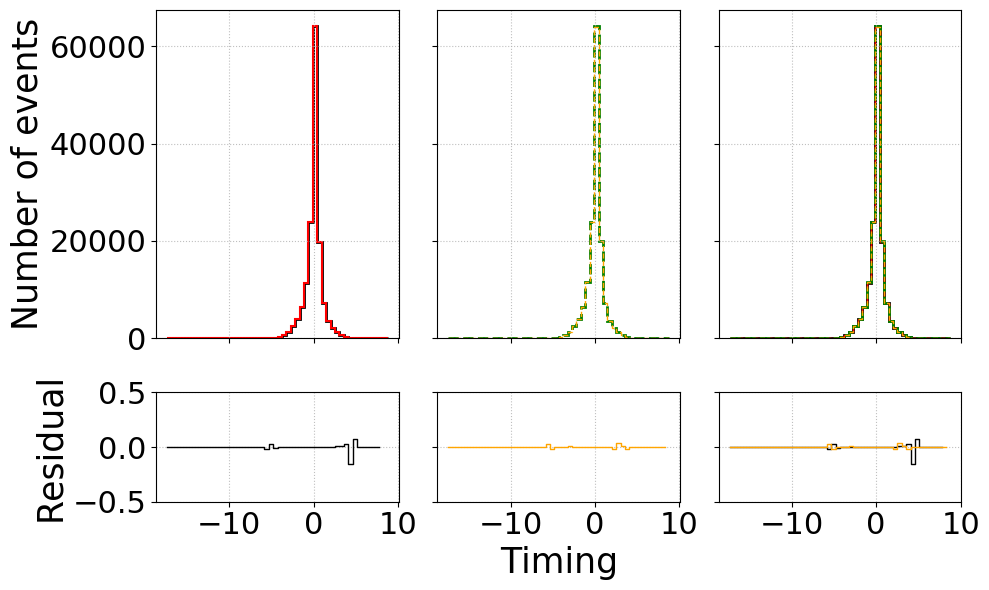

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:479: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:480: RuntimeWarning: divide by zero encountered in true_divide


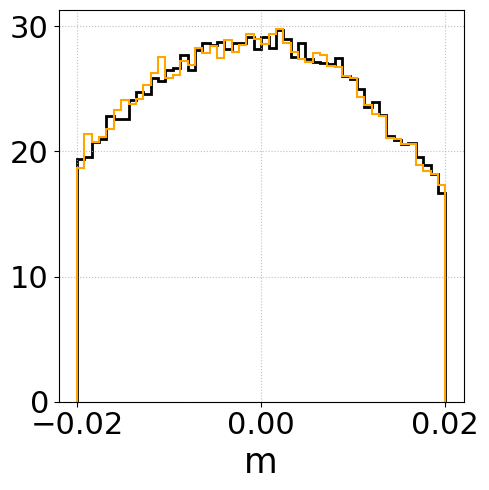

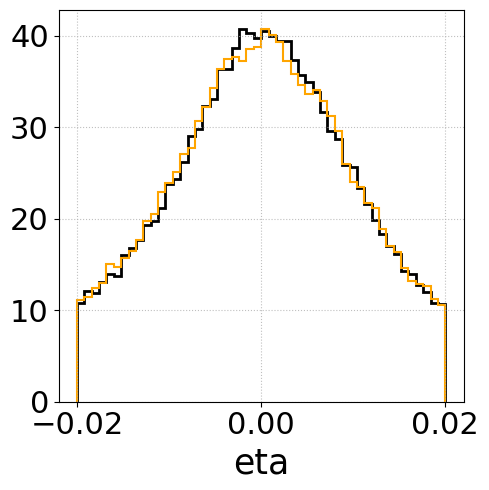

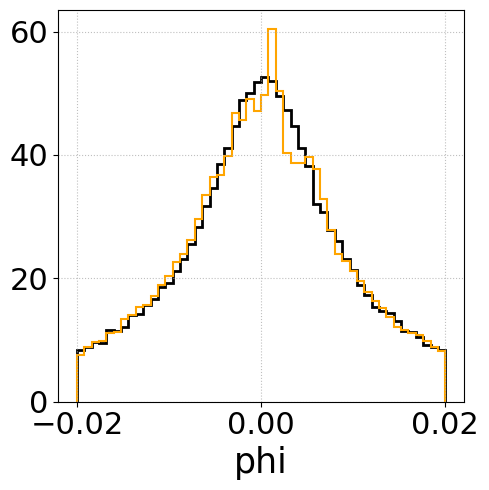

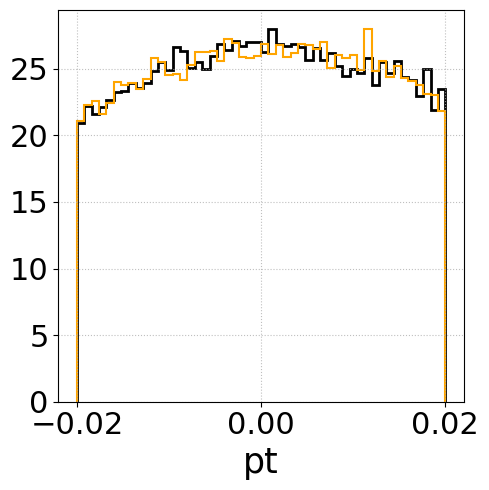

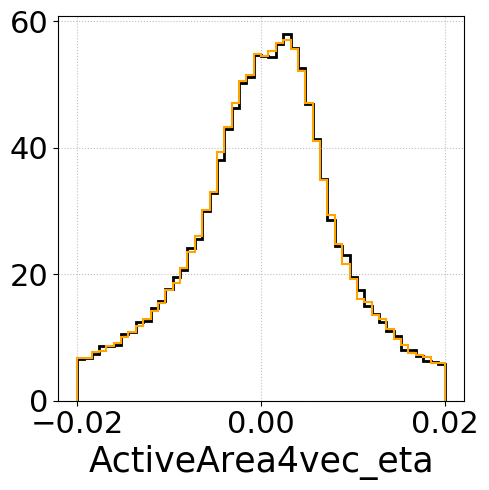

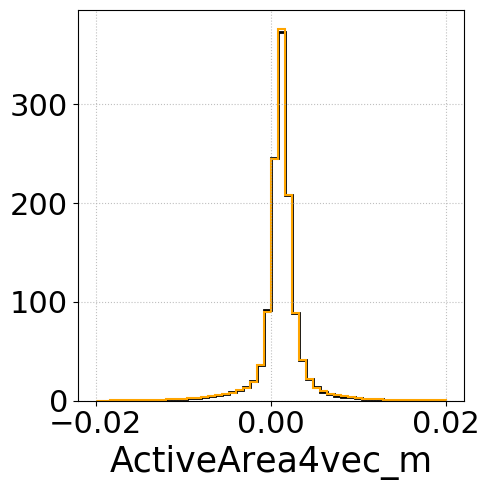

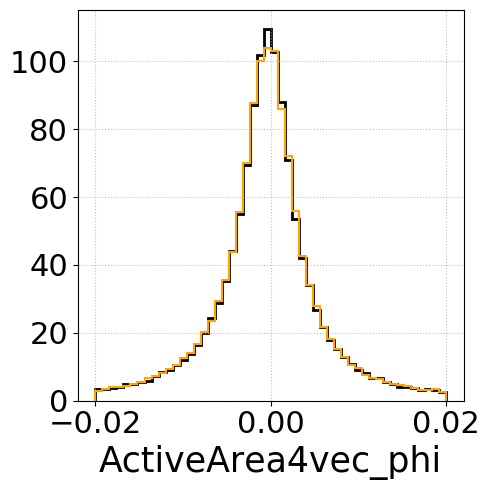

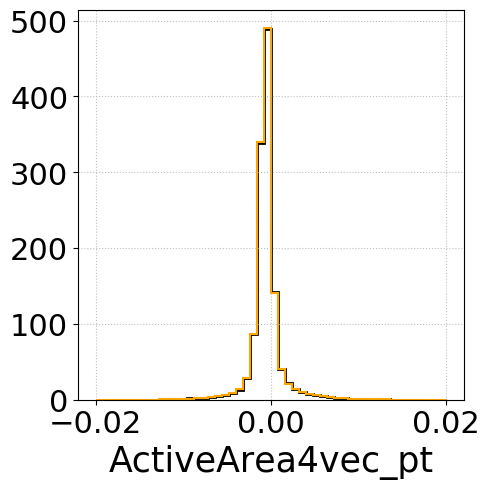

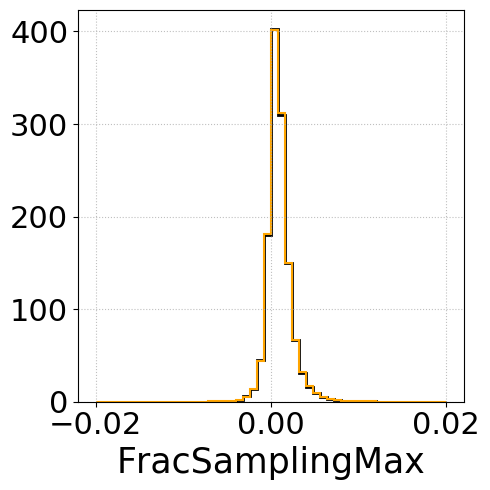

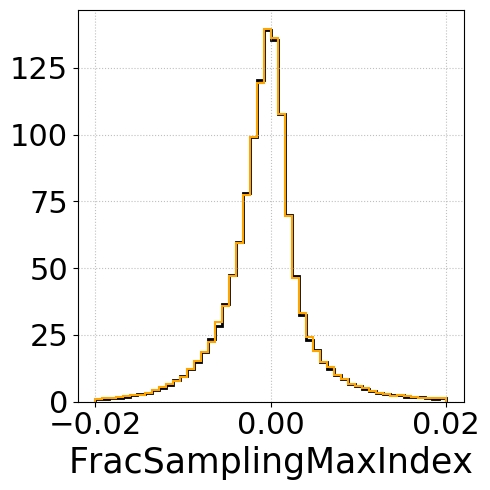

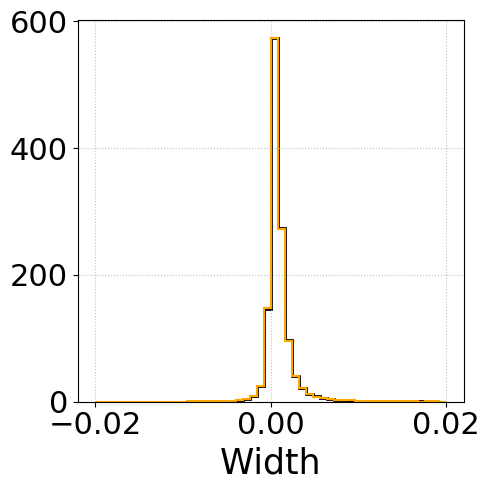

/usr/lib/python3.7/site-packages/numpy/core/_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
/usr/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


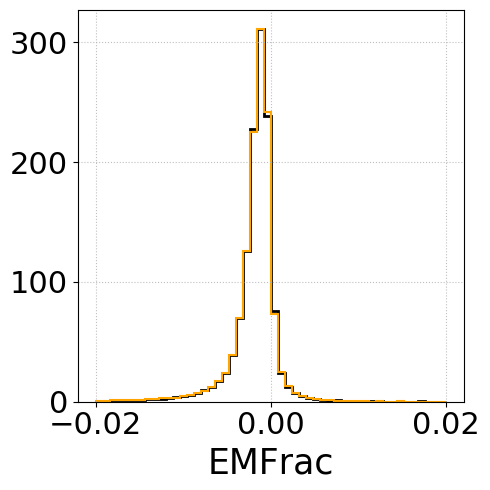

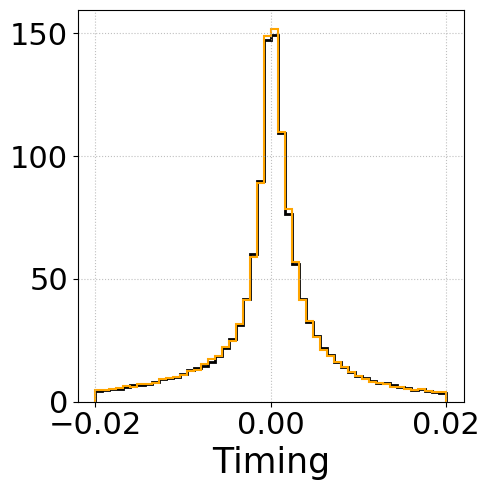

In [19]:

import sys
BIN = '../../'
sys.path.append(BIN)
import utils
import matplotlib.pyplot as plt
from scipy import stats
import my_matplotlib_style as ms

%matplotlib inline

%matplotlib inline
import sys
BIN = '../../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from nn_utils import AE_big, AE_3D_200
from utils import plot_activations


# Load data
train = pd.read_pickle(BIN + 'processed_data/aod/uncompressed_all_jets_train.pkl')
test = pd.read_pickle(BIN + 'processed_data/aod/uncompressed_all_jets_test.pkl')
#n_features = len(train.loc[0])


#Remove zero mass jets

train = train.loc[train["m"] > 0.08]
test = test.loc[test["m"] > 0.08]

train = train.loc[train["m"] < 15000]
test = test.loc[test["m"] < 15000]

#train = train.loc[train["pt"] > 10000]
#test = test.loc[test["pt"] > 10000]

#train = train.loc[train["pt"] < 25000]
#test = test.loc[test["pt"] < 25000]

#train = train.loc[train["pt"] > 25000]#.iloc(:1)
#test = test.loc[test["pt"] > 25000]

#Shuffle datasets
train = train.sample(frac=1)
test = test.sample(frac=1)

# Normalize

# Custom normalization for AOD data
eta_div = 5
emfrac_div = 1.6
negE_div = 1.6
phi_div = 3
m_div = 1.8
width_div = .6
N90_div = 20
timing_div = 40
hecq_div = 1
centerlambda_div = 2
secondlambda_div = 1
secondR_div = .6
larqf_div = 2.5
pt_div = 1.2
centroidR_div = 0.8
area4vecm_div = 0.18
area4vecpt_div = 0.7
area4vec_div = 0.8
Oot_div = 0.3
larq_div = 0.6

log_add = 100
log_sub = 2

centroidR_sub = 3

area4vecm_sub = 0.15


m_add = 1
pt_sub = 1.3
eta_div = 5
phi_div = 3

branches = ["ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "Jvt", "JVFCorr" ,"JvtRpt", "FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac","Timing"]

means = [train[k].mean() for k in branches]
stds = [train[k].std() for k in branches]



for data in [train,test]:
    #data['m'] = (np.log10(data['m'])-3.6)
    data['m'] = np.log10(data['m'] + m_add) / m_div -1.4
    data['eta'] = data['eta'] / eta_div
    
    data['phi'] = data['phi'] / phi_div
    
    #data['pt'] = (np.log10(data['pt']/1000-10)) -0.7
    data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div -2.4
    
    #data['Timing'] = np.log10(data['Timing'])
    
    for k in range(0,len(branches)):
        data[branches[k]] = (data[branches[k]] - means[k])/stds[k]
    
    #data['Timing'] = data['Timing']/50
    
    #data['FracSamplingMaxIndex'] = data['FracSamplingMaxIndex']/20
    


train = train.loc[train["m"] > 0]
test = test.loc[test["m"] > 0]

train = train.drop("JvtRpt",axis=1)
test = test.drop("JvtRpt",axis=1)

train = train.drop("JVFCorr",axis=1)
test = test.drop("JVFCorr",axis=1)

train = train.drop("Jvt",axis=1)
test = test.drop("Jvt",axis=1)

print(means)

del means[4:7]
del stds[4:7]

print(means)

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

# Load data
trainc = pd.read_pickle(BIN + 'processed_data/aod/compressed_all_jets_train.pkl')
testc = pd.read_pickle(BIN + 'processed_data/aod/compressed_all_jets_test.pkl')
#n_features = len(train.loc[0])


#Remove zero mass jets

trainc = trainc.loc[trainc["m"] > 0.08]
testc = testc.loc[testc["m"] > 0.08]

trainc = trainc.loc[trainc["m"] < 15000]
testc = testc.loc[testc["m"] < 15000]

#train = train.loc[train["pt"] > 10000]
#test = test.loc[test["pt"] > 10000]

#train = train.loc[train["pt"] < 25000]
#test = test.loc[test["pt"] < 25000]

#train = train.loc[train["pt"] > 25000]#.iloc(:1)
#test = test.loc[test["pt"] > 25000]

#Shuffle datasets
trainc = trainc.sample(frac=1)
testc = testc.sample(frac=1)

# Normalize

# Custom normalization for AOD data
eta_div = 5
emfrac_div = 1.6
negE_div = 1.6
phi_div = 3
m_div = 1.8
width_div = .6
N90_div = 20
timing_div = 40
hecq_div = 1
centerlambda_div = 2
secondlambda_div = 1
secondR_div = .6
larqf_div = 2.5
pt_div = 1.2
centroidR_div = 0.8
area4vecm_div = 0.18
area4vecpt_div = 0.7
area4vec_div = 0.8
Oot_div = 0.3
larq_div = 0.6

log_add = 100
log_sub = 2

centroidR_sub = 3

area4vecm_sub = 0.15


m_add = 1
pt_sub = 1.3
eta_div = 5
phi_div = 3

branches = ["ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "Jvt", "JVFCorr" ,"JvtRpt", "FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac","Timing"]
branchesreduced = ["ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac","Timing"]

meansc = [trainc[k].mean() for k in branches]
stdsc = [trainc[k].std() for k in branches]

for data in [trainc,testc]:
    #data['m'] = (np.log10(data['m'])-3.6)
    data['m'] = np.log10(data['m'] + m_add) / m_div -1.4
    data['eta'] = data['eta'] / eta_div
    
    data['phi'] = data['phi'] / phi_div
    
    #data['pt'] = (np.log10(data['pt']/1000-10)) -0.7
    data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div -2.4
    


    data[branches[0]] = (data[branches[0]] - means[0])/stds[0]
    data[branches[1]] = (data[branches[1]] - means[1])/stds[1]
    data[branches[2]] = (data[branches[2]] - means[2])/stds[2]
    data[branches[3]] = (data[branches[3]] - means[3])/stds[3]
    data[branches[7]] = (data[branches[7]] - means[4])/stds[4]
    data[branches[8]] = (data[branches[8]] - means[5])/stds[5]
    data[branches[9]] = (data[branches[9]] - means[6])/stds[6]
    data[branches[10]] = (data[branches[10]] - means[7])/stds[7]
    data[branches[11]] = (data[branches[11]] - means[8])/stds[8]


trainc = trainc.loc[trainc["m"] > 0]
testc = testc.loc[testc["m"] > 0]

trainc = trainc.drop("JvtRpt",axis=1)
testc = testc.drop("JvtRpt",axis=1)

trainc = trainc.drop("JVFCorr",axis=1)
testc = testc.drop("JVFCorr",axis=1)

trainc = trainc.drop("Jvt",axis=1)
testc = testc.drop("Jvt",axis=1)

del meansc[4:7]
del stdsc[4:7]

train_xc = trainc
test_xc = testc
train_yc = train_xc  # y = x since we are building and AE
test_yc = test_xc

train_dsc = TensorDataset(torch.tensor(train_xc.values), torch.tensor(train_yc.values))
valid_dsc = TensorDataset(torch.tensor(test_xc.values), torch.tensor(test_yc.values))

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']
line_style = ['--', '-']
colors = ['red', 'c']
markers = ['*', 's']

branches=["pt","eta","phi","m","ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac", "Timing"]
"""
%matplotlib inline
n_bins = 200
alph = 0.8
for kk in np.arange(13):
    plt.figure(kk + 13)
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_data, bin_edges, _ = plt.hist(trainc[branches[kk]], color=colors[0], label='Input', alpha=0.6, bins=n_bins)
    #n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(branches[kk])
    plt.xlabel(branches[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)
    plt.show()
"""
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=2048)

db = basic_data.DataBunch(train_dl, valid_dl)


class AE_3D_200_wide(nn.Module):
    def __init__(self, n_features=16):
        super(AE_3D_200_wide, self).__init__()
        self.n = 200
        self.en1 = nn.Linear(n_features, self.n)
        self.en2 = nn.Linear(self.n, self.n)
        self.en3 = nn.Linear(self.n, self.n)
        self.en4 = nn.Linear(self.n, 10)
        self.de1 = nn.Linear(10, self.n)
        self.de2 = nn.Linear(self.n, self.n)
        self.de3 = nn.Linear(self.n, self.n)
        self.de4 = nn.Linear(self.n, n_features)
        self.tanh = nn.LeakyReLU()
        

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-200-3-200-200-200-out'

model = AE_3D_200_wide(13).double()

#model = AE_3D_200().double()

loss_func = nn.MSELoss()


bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd =1e-2
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

train_dlc, valid_dlc = get_data(train_dsc, valid_dsc, bs=2048)

dbc = basic_data.DataBunch(train_dlc, valid_dlc)

modelc = AE_3D_200_wide(13).double()

learnc = basic_train.Learner(data=dbc, model=modelc, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

#model.to('cpu')
learn.load('uncompressed_16D_13')
learnc.load('uncompressed_16D_13')

# Histograms
idxs = (0, 150000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
datac = torch.tensor(test_xc[idxs[0]:idxs[1]].values)

pred = model(data).detach().numpy()
predc = modelc(datac).detach().numpy()


branches = ["ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "Jvt", "JVFCorr" ,"JvtRpt", "FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac","Timing"]



for d in [data,pred, datac, predc]:
    #data['m'] = (np.log10(data['m'])-3.6)
    
    d[:, 3] = np.power(10,(d[:, 3]+1.4)*m_div)-m_add
    
    d[:, 1] = d[:, 1] * eta_div
    
    d[:, 2] = d[:, 2] *phi_div
    
    d[:, 0] = np.power(10,(d[:, 0]+2.4)*pt_div)+pt_sub

    #d[:, 4] = (d[:, 4]*stds[0])+means[0]
    kk = 0
    while kk < len(means)-1:
        d[:, 4+kk] = (d[:, 4+kk]*stds[kk])+means[kk]
        kk+=1


def getRatio(bin1,bin2):
    # Sanity check
    if len(bin1) != len(bin2):
        print("Cannot make ratio!")
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    # The ratio can of course be expanded with eg. error
    return bins    

variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']+branchesreduced

branches = ["m","eta","phi","pt"]+branchesreduced

alph = 0.8
n_bins = 50
for kk in range(13):
    plt.figure(kk + 13)
    fig, axs = plt.subplots(ncols=3,nrows=2, figsize=(10,6),gridspec_kw={'height_ratios': [3, 1]}, sharex=True, sharey='row')
    n_hist_data, bin_edges, _ = axs[0][0].hist(data[:, kk], color='black', label='Input', alpha=1, bins=n_bins, histtype="step",linewidth=2)
    n_hist_pred, _, _ = axs[0][0].hist(pred[:, kk], color=colors[0], label='Output', alpha=1, bins=bin_edges, histtype='step',linewidth=1.5)
    n_hist_datac, bin_edgesc, _ = axs[0][1].hist(datac[:, kk], color='green', label='Compressed Input', alpha=1, bins=bin_edges, histtype="step",linewidth=2,linestyle=('dashed'))
    n_hist_predc, _, _ = axs[0][1].hist(predc[:, kk], color='orange', label='Compressed Output', alpha=1, bins=bin_edges, histtype='step',linewidth=1,linestyle=('dashed'))
    
    _, _, _ = axs[0][2].hist(data[:, kk], color='black', label='Input', alpha=1, bins=bin_edges, histtype="step",linewidth=2)
    _, _, _ = axs[0][2].hist(pred[:, kk], color=colors[0], label='Output', alpha=1, bins=bin_edges, histtype='step',linewidth=1)
    _, _, _ = axs[0][2].hist(datac[:, kk], color='green', label='Compressed Input', alpha=1, bins=bin_edges, histtype="step",linewidth=2,linestyle=('dashed'))
    _, _, _ = axs[0][2].hist(predc[:, kk], color='orange', label='Compressed Output', alpha=1, bins=bin_edges, histtype='step',linewidth=1,linestyle=('dashed'))
    
    #plt.suptitle(train_x.columns[kk])
    axs[1][1].set(xlabel=variable_list[kk])
    axs[0][0].set(ylabel='Number of events')
    ms.sciy()
    # plt.yscale('log')
    #axs[0][2].legend(loc=8,framealpha=1)
    
    #axs[0][1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), fancybox=True, shadow=True)
    
    rat = getRatio(n_hist_data,n_hist_pred)
    ratc = getRatio(n_hist_datac,n_hist_predc)
    axs[1][0].step(bin_edges[:-1],rat, color='black',linewidth=1)
    axs[1][1].step(bin_edges[:-1],ratc, color='orange',linewidth=1)
    axs[1][0].set(ylabel='Residual')
    axs[1][0].set( ylim=(-0.5, 0.5))
    axs[1][1].set( ylim=(-0.5, 0.5))
    axs[1][0].ticklabel_format(style='plain')
    axs[1][1].ticklabel_format(style='plain')
    
    axs[1][2].step(bin_edges[:-1],rat, color='black',linewidth=1)
    axs[1][2].step(bin_edges[:-1],ratc, color='orange',linewidth=1)
    axs[1][2].set( ylim=(-0.5, 0.5))
    axs[1][2].ticklabel_format(style='plain')
    
    plt.tight_layout()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    
    plt.savefig("13_10_comp_histogram_" + train_x.columns[kk])
    plt.show()

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']
alph = 0.5
n_bins = 200

residual_strings = [r'$(m_{comp} - m_{raw}) / m_{raw}$',
                        r'$(\eta_{comp} - \eta_{raw}) / \eta_{raw}$',
                        r'$(\phi_{comp} - \phi_{raw}) / \phi_{raw}$',
                        r'$(p_{T,comp} - p_{T,raw}) / p_{T,raw}$']


residuals = (pred - data.detach().numpy())/data.detach().numpy()
residualsc = (predc - datac.detach().numpy())/datac.detach().numpy()

#residuals = residuals.loc[residuals["m"] >= 1.]
#residualsmc = residualsmc.loc[residualsmc["m"] >= 1.]

#print(residuals.head(100))

#dfmc = dfmc.loc[dfmc["pt"] != 0.0]

#respt = (np.array(pt)-np.array(ptc))/np.array(pt)

#respt = [(dfc["pt"][i]-df["pt"][i])/df["pt"][i]]

branches = ["m","eta","phi","pt"]+branchesreduced

#fig,axs = plt.subplots(1,13, figsize=(16,5))

n_bins = 50
axisrange=(-0.02,0.02)
for kk in np.arange(13):
    plt.figure(figsize=(5,5))
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals compressed', alpha=1, bins=n_bins, range=axisrange, density=True, color="black", histtype='step', linewidth=2)
    n_hist_pred, bin_edges, _ = plt.hist(
        residualsc[:, kk], label='Residuals', alpha=1, bins=n_bins, range=axisrange, density=True, histtype='step', color='orange', linewidth=1.5)
    #axs[kk].xlabel(branches[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    #plt.yscale("log")
    #ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    stdmc = np.std(residualsc[:, kk])
    std_errmc = utils.std_error(residualsc[:, kk])
    meanmc = np.nanmean(residualsc[:, kk])
    semmc = stats.sem(residualsc[:, kk], nan_policy='omit')
    axes = plt.gca()
    #text = 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f\nComp. mean = %f$\pm$%f\nComp. $\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err, meanmc, semmc, stdmc, std_errmc)
    #axes.annotate(text, (0,0), (0, -60), xycoords='axes fraction', textcoords='offset points', va='top', fontsize='large')
    axes.set(xlabel=branches[kk])
    #axes.suptitle(branches[kk])
    #axes.text(.1, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
    #         horizontalalignment='center', verticalalignment='center', transform=axes.transAxes, fontsize=12)
    #fig_name = 'trainforever_residual_%s' % branches[kk]
    plt.tight_layout()
    plt.savefig('13_10_residuals_'+branches[kk])
    plt.show()
    
